In [51]:
from sklearn import linear_model, metrics
import numpy as np
import pandas as pd
import math

from tqdm import tqdm

import matplotlib.pyplot as plt
import string

from nlp_preprocessing_toolbox.helper import *
from nlp_preprocessing_toolbox.helper import __fixation

In [117]:
df_raw = sentence_splitter_load_and_parse_corpus()

	Parsing the corpus.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7803/7803 [00:00<00:00, 32047.06it/s]


# Naive Bayes Sentence Splitting

In [118]:
time_lags = [-1,+1]

for col in time_lags:
    if col >= 0: df_raw["t+"+str(col)] = df_raw.char.shift(col)
    else: df_raw["t"+str(col)] = df_raw.char.shift(col)

df_raw = df_raw.dropna()

for col in time_lags:
    if col >= 0: df_raw["t+"+str(col)] = df_raw["t+"+str(col)].astype(str)
    else: df_raw["t"+str(col)] = df_raw["t"+str(col)].astype(str)

df_raw["char"] = df_raw["char"].astype(str)

In [119]:
time_cols = []
for col in time_lags:
    if col >= 0: time_cols.append("t+"+str(col))
    else: time_cols.append("t"+str(col))

In [120]:
# df_raw["text"] = [row["t-2"] + row["t-1"] + row["char"] + row["t+1"] + row["t+2"] for i, row in df_raw.iterrows()]
df_raw["text"] = [row["t-1"] + row["char"] + row["t+1"] for i, row in df_raw.iterrows()]

In [121]:
punc_df = df_raw[df_raw["char"].isin(list(string.punctuation))].reset_index(drop=True)
punc_df

,char,label,t-1,t+1,text
0,.,1,,z,.z
1,.,1,,m,.m
2,.,1,,ı,.ı
3,",",0,,m,",m"
4,',0,y,a,y'a
...,...,...,...,...,...
20313,",",0,,z,",z"
20314,.,1,,z,.z
20315,"""",0,H,,"H"""
20316,.,1,,r,.r


In [122]:
prob_df = pd.DataFrame(columns = sorted(list(set(punc_df[["char"] + time_cols].values.reshape(-1,1).T[0])), key = lambda x: x), index = [0,1])

p_cls = {
    0:len(punc_df[punc_df.label == 0]) / len(punc_df),
    1:len(punc_df[punc_df.label == 1]) / len(punc_df)
}

for idx in prob_df.index:
    df_class = punc_df[punc_df.label == idx]
    chars = df_class[["char"] + time_cols].values.reshape(-1,1).T[0]
    no_uniq_chars = len(set(chars))
    total_c = len(chars)
    
    for col in prob_df.columns:
        char_c = len(chars[chars == col])
        prob_df.iloc[idx][col] = math.log((char_c + 1) / (total_c + no_uniq_chars)) + math.log(p_cls[idx])

In [123]:
preds = []
prob_dict = prob_df.to_dict()
for idx, row in tqdm(punc_df.iterrows()):
    char_prob_dict = {}
    for cls in [0,1]:
        values = list(map(lambda x: prob_dict[x][cls], list(row.text)))
        char_prob_dict[cls] = np.prod(values)
    preds.append(max(char_prob_dict, key=char_prob_dict.get))

20318it [00:01, 17918.20it/s]


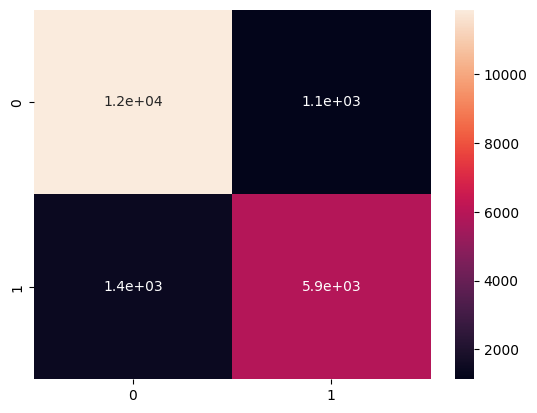

In [124]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = punc_df["label"].values
y_pred = preds
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
plt.show()

In [125]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

print("Acc:",round(((tn + tp) / (tp + tn + fp + fn)) * 100,2))
print("Pre:",round(((tp) / (fp + tp)) * 100,2))
print("Rec:",round(((tp) / (fn + tp)) * 100,2))

Acc: 87.41
Pre: 83.85
Rec: 80.48


## Splitting

In [132]:
text = '''Saçma ve Gereksiz Bir Yazı.
Bakkaldan 5 TL'lik 2 çikola-
ta al. 12.02.2018 tarihinde saat tam 15:45'te yap-
malıyız bu işi. Tamam mı? Benimle esatmahmutbayol@gmail.com 
adresinden iletişime geçebilirsin. Yarışta 1. oldu. Doç. Dr. 
Esat Bayol'un(Böyle bir ünvanım yok!) yanından geliyorum.
12 p.m. mi yoksa 12 a.m. mi? 100 milyon insan gelmiş! www.deneme.com.tr 
adresinden sitemizi inceleyebilirsin. 24 Eylül 2018 Pazartesi günü ge-
lecekmiş. 19 Mayıs'ı coşkuyla kutladık.
Sonra dedi ki "Ben seni sevmiyorum."'''


text = " " + __fixation(text).replace("\n", " ") + " "

In [133]:
lines = []
for idx, char in enumerate(text):
    row = {
        "char" : char
    }
    lines.append(row)

df_text = pd.DataFrame.from_records(lines)


def preprocess(df_raw):
    time_lags = [-1,+1]

    for col in time_lags:
        if col >= 0: df_raw["t+"+str(col)] = df_raw.char.shift(col)
        else: df_raw["t"+str(col)] = df_raw.char.shift(col)

    df_raw = df_raw.dropna()
    
    time_lags = [-1,1] 
    for col in time_lags:
        if col >= 0: df_raw["t+"+str(col)] = df_raw["t+"+str(col)].astype(str)
        else: df_raw["t"+str(col)] = df_raw["t"+str(col)].astype(str)

    df_raw["char"] = df_raw["char"].astype(str)
    df_raw["text"] = [row["t-1"] + row["char"] + row["t+1"] for i, row in df_raw.iterrows()]
    
    return df_raw

df_text = preprocess(df_text)
df_text

/tmp/ipykernel_19950/2479225002.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  else: df_raw["t"+str(col)] = df_raw["t"+str(col)].astype(str)
/tmp/ipykernel_19950/2479225002.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if col >= 0: df_raw["t+"+str(col)] = df_raw["t+"+str(col)].astype(str)
/tmp/ipykernel_19950/2479225002.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

,char,t-1,t+1,text
1,S,a,,aS
2,a,ç,S,çaS
3,ç,m,a,mça
4,m,a,ç,amç
5,a,,m,am
...,...,...,...,...
502,r,u,o,uro
503,u,m,r,mur
504,m,.,u,.mu
505,.,"""",m,""".m"


In [134]:
preds = []
prob_dict = prob_df.to_dict()
for idx, row in tqdm(df_text.iterrows()):
    if row["char"] in list(string.punctuation):
        try:
            char_prob_dict = {}
            for cls in [0,1]:
                values = list(map(lambda x: prob_dict[x][cls], list(row.text)))
                char_prob_dict[cls] = np.prod(values)
            preds.append(max(char_prob_dict, key=char_prob_dict.get))
        except:
            preds.append(0)
    else:
        preds.append(0)

506it [00:00, 15027.07it/s]


In [135]:
df_text["label"] = preds

In [136]:
tokens = []
last_idx = 0
temp = ""
for idx, row in df_text.iterrows():
    if row.label == 0: temp += row.char
    elif row.label == 1:
        temp += row.char
        tokens.append(temp)
        temp = ""
        last_idx = idx

In [137]:
tokens

['Saçma ve Gereksiz Bir Yazı.',
 " Bakkaldan 5 TL'lik 2 çikolata  al. 12.02.2018 tarihinde saat tam 15:45'te yapmalıyız  bu işi.",
 ' Tamam mı? Benimle esatmahmutbayol@gmail.com  adresinden iletişime geçebilirsin. Yarışta 1. oldu.',
 ' Doç. Dr.',
 "  Esat Bayol'un(Böyle bir ünvanım yok!) yanından geliyorum.",
 ' 12 p.m.',
 ' mi yoksa 12 a.m.',
 ' mi? 100 milyon insan gelmiş! www.deneme.com.tr  adresinden sitemizi inceleyebilirsin. 24 Eylül 2018 Pazartesi günü gelecekmiş.',
 "  19 Mayıs'ı coşkuyla kutladık."]

# Logistic Regression

In [96]:
df_raw = pd.read_csv('example.csv')

# df_add = df_raw[(df_raw["#is it number"] == True) & (df_raw["#is next char punc"] == True)]
# for i in range(100):
#     df_raw = pd.concat([df_raw,df_add])

df = df_raw.copy()
df = df[df.columns[1:]]
df = df.astype(int)

In [97]:
df_raw.head()

,char,#is it number,#is it punctuation,#is it period,#is next whitespace,#is previos char number,#is next char number,#is next char period,label
0,1,True,False,False,False,False,True,False,0
1,9,True,False,False,False,True,True,False,0
2,3,True,False,False,False,True,True,False,0
3,6,True,False,False,True,True,True,False,1
4,y,False,False,False,False,False,False,False,0


In [98]:
train_test_split = int(len(df)*0.8)
dfTrain, dfTest = df[0:train_test_split], df[train_test_split:]

X_train = dfTrain.values[:,0:-1]
y_train = dfTrain.values[:,-1]

X_test = dfTest.values[:,0:-1]
y_test = dfTest.values[:,-1]

In [99]:
logr = linear_model.LogisticRegression()
logr.fit(X_train,y_train)

LogisticRegression()

C:\Users\gocal\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


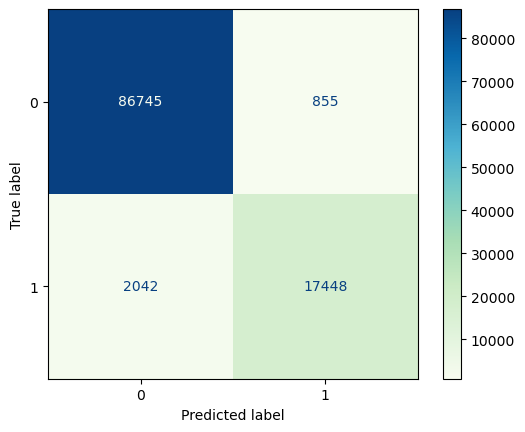

In [100]:
confusion_matrix = metrics.plot_confusion_matrix(logr, X_test, y_test, cmap = "GnBu")
plt.show()

In [111]:
text = '''Çünkü ben de o yaşadığı çevreyi kirleterek bozulmasına neden olan, tüm uyarılara
kulağını tıkayan soya aitim. Kimileri buna kader diyordu, kimileri unut. Bu da
zaman ister, emek ister. İki veli dokunulsa ağlayacaktı. Bu meslek böyledir.
Filmde kamburunu çıkarmış eski Yugoslav lideri, iki kişinin arasında elleri
önden bağlı, cezaevi avlusunda yürüyor. Sabahları hiçbir şey yemeden içmeden,
paldür küldür çıkıyorum evden. Bu albüm hit şarkı çıkarmaz, dedim.
12.02.2018 tarihinde saat tam 15:45'te burada ol.'''

text = '''Saçma ve Gereksiz Bir Yazı.
Bakkaldan 5 TL'lik 2 çikola-
ta al. 12.02.2018 tarihinde saat tam 15:45'te yap-
malıyız bu işi. Tamam mı? Benimle esatmahmutbayol@gmail.com 
adresinden iletişime geçebilirsin. Yarışta 1. oldu. Doç. Dr. 
Esat Bayol'un(Böyle bir ünvanım yok!) yanından geliyorum.
12 p.m. mi yoksa 12 a.m. mi? 100 milyon insan gelmiş! www.deneme.com.tr 
adresinden sitemizi inceleyebilirsin. 24 Eylül 2018 Pazartesi günü ge-
lecekmiş. 19 Mayıs'ı coşkuyla kutladık.
Sonra dedi ki "Ben seni sevmiyorum."'''

text = __fixation(text)

text = " " + text.replace("\n", " ") + " "
lines = []
for idx, char in enumerate(text):

    isItPunc, isItPeriod, isItWhitespace, isNextWhitespace, isPrevNumber, isNextNumber, isNextPunc, isItNum, isNextPeriod = \
        False, False, False, False, False, False, False, False, False
    
    if char != " " and idx != 0 and idx != len(text)-1:
        if char in string.punctuation                   : isItPunc = True
        if char == "."                                  : isItPeriod = True
        if char.isnumeric()                             : isItNum = True
        if text[idx+1] == " "                           : isNextWhitespace = True
        if text[idx+1] == "."                           : isNextPeriod = True
        if text[idx-1].isnumeric()                      : isPrevNumber = True
        if text[idx+1].isnumeric()                      : isNextNumber = True
        if text[idx+1] in string.punctuation            : isNextPunc = True

        row = {
                "char" : char,
                "#is it number" : isItNum,
                "#is it punctuation" : isItPunc,
                "#is it period" : isItPeriod,
                "#is next whitespace" : isNextWhitespace,
                "#is previos char number" : isPrevNumber,
                "#is next char number" : isNextNumber,
#                 "#is next char punc" : isNextPunc,
                "#is next char period" : isNextPeriod,
        }
        lines.append(row)

df_text = pd.DataFrame.from_records(lines)
df_real_test = df_text.values[:,1:]
df_real_test

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, True],
       [False, True, True, ..., False, False, False],
       [False, True, False, ..., False, False, False]], dtype=object)

In [112]:
pred = logr.predict(df_real_test)

In [113]:
df_text["label"] = pred
df_text

,char,#is it number,#is it punctuation,#is it period,#is next whitespace,#is previos char number,#is next char number,#is next char period,label
0,S,False,False,False,False,False,False,False,0
1,a,False,False,False,False,False,False,False,0
2,ç,False,False,False,False,False,False,False,0
3,m,False,False,False,False,False,False,False,0
4,a,False,False,False,True,False,False,False,1
...,...,...,...,...,...,...,...,...,...
427,r,False,False,False,False,False,False,False,0
428,u,False,False,False,False,False,False,False,0
429,m,False,False,False,False,False,False,True,1
430,.,False,True,True,False,False,False,False,0


In [114]:
tokens = []
last_idx = 0
temp = ""
for idx, row in df_text.iterrows():
    if row.label == 0: temp += row.char
    elif row.label == 1:
        temp += row.char
        tokens.append(temp)
        temp = ""
        last_idx = idx

In [115]:
tokens

['Saçma',
 've',
 'Gereksiz',
 'Bir',
 'Yazı',
 '.',
 'Bakkaldan',
 '5',
 "TL'lik",
 '2',
 'çikolata',
 'al',
 '.',
 '12',
 '.02',
 '.2018',
 'tarihinde',
 'saat',
 'tam',
 "15:45'te",
 'yapmalıyız',
 'bu',
 'işi',
 '.',
 'Tamam',
 'mı?',
 'Benimle',
 'esatmahmutbayol@gmail',
 '.com',
 'adresinden',
 'iletişime',
 'geçebilirsin',
 '.',
 'Yarışta',
 '1',
 '.',
 'oldu',
 '.',
 'Doç',
 '.',
 'Dr',
 '.',
 'Esat',
 "Bayol'un(Böyle",
 'bir',
 'ünvanım',
 'yok!)',
 'yanından',
 'geliyorum',
 '.',
 '12',
 'p',
 '.m',
 '.',
 'mi',
 'yoksa',
 '12',
 'a',
 '.m',
 '.',
 'mi?',
 '100',
 'milyon',
 'insan',
 'gelmiş!',
 'www',
 '.deneme',
 '.com',
 '.tr',
 'adresinden',
 'sitemizi',
 'inceleyebilirsin',
 '.',
 '24',
 'Eylül',
 '2018',
 'Pazartesi',
 'günü',
 'gelecekmiş',
 '.',
 '19',
 "Mayıs'ı",
 'coşkuyla',
 'kutladık',
 '.',
 'Sonra',
 'dedi',
 'ki',
 '"Ben',
 'seni',
 'sevmiyorum',
 '."']

In [122]:
df_text[50:100]

,char,#is it number,#is it punctuation,#is it period,#is next whitespace,#is previos char number,#is next char number,#is next char period,label
50,.,False,True,True,True,False,False,False,1
51,1,True,False,False,False,False,True,False,0
52,2,True,False,False,False,True,False,True,1
53,.,False,True,True,False,True,True,False,0
54,0,True,False,False,False,False,True,False,0
55,2,True,False,False,False,True,False,True,1
56,.,False,True,True,False,True,True,False,0
57,2,True,False,False,False,False,True,False,0
58,0,True,False,False,False,True,True,False,0
59,1,True,False,False,False,True,True,False,0
